# Criterion for convergence in backward error after fault

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.sparse.linalg import LinearOperator
from scipy.linalg import solve_triangular
from sys import stdout
import math


## Import modules

In [3]:
from Experiment import *
from Parameters import *
from Fault import *
from Algorithm import *
from Utils import *

## Algorithm initialization

In [4]:
from gmres import *
import gmres_display

### algorithm parameters

In [5]:
# parameters that won't change during the whole experiment
epsilon = 1.e-10

algorithm_parameters = Parameters()
algorithm_parameters["restart"] = None
algorithm_parameters["tol"] = epsilon
algorithm_parameters["save_data"] = {"iteration_count",
                                     "residual",
                                     "residuals",
                                     #"true_residual",
                                     #"true_residuals",
                                     #"orthogonality",
                                     #"arnoldi",
                                     "faults",
                                     "H",
                                     "V",
                                     "givens",
                                     #"y",
                                     #"checksum",
                                     #"threshold",
                                     #"criteria",
                                     #"delta",
                                     #"true_delta"
                                    }

def faulty_product(A, Faulty = None):
    if Faulty:
        return lambda v: Faulty.product(A, v)
    else:
        return lambda v: A.dot(v)

### implementation

In [6]:
def implementation(self, input, algorithm_parameters, experiment_parameters):
    A = input["A"]
    b = input["b"]
    x0= input["x0"]
    
    parameters = algorithm_parameters.copy()
    parameters.update(experiment_parameters)
    
    n = A.shape[0]
    normb = np.linalg.norm(b)
    maxiter = parameters.get("maxiter", n)
    tol = parameters.get("tol", 1.e-10)
    restart = parameters.get("restart", None)
    m = restart if restart else maxiter
    save_data = parameters.get("save_data", {})
    A1T = A.sum(axis=0)
    
    if "residuals" in save_data:
        self.data["residuals"] = [1.]
    if "true_residuals" in save_data:    
        self.data["true_residuals"] = [1.]
    if "measured_checksum" in save_data:
        self.data["measured_checksum"] = [0.]
    if "true_checksum" in save_data:
        self.data["true_checksum"] = [0.]
    if "checksum" in save_data:
        self.data["checksum"] = [0.]
    if "true_delta" in save_data:
        self.data["true_delta"] = [0.]
    if "delta" in save_data:
        self.data["delta"] = [0.]
    if "y" in save_data:
        self.data["y"] = []
    
    if parameters.get("vulnerable", True):
        faulty = Fault(parameters.get("fault_parameters", Parameters()))
    else:
        faulty = None
    A_ = LinearOperator((n, n), 
                        matvec=faulty_product(A, faulty),
                        dtype=A.dtype)

    def callback(iter_num, resid, work, work2, ijob):
        R = work[0*n:1*n]
        S = work[1*n:2*n]
        W = work[2*n:3*n]
        Y = work[3*n:4*n]
        AV= work[4*n:5*n]
        V = work[5*n:(5+iter_num)*n]
        v = work[(5+iter_num) * n:(6 + iter_num)*n]
        H = work2[:iter_num*(m+1)]
        c = work2[m*(m+1):m*(m+2)]
        s = work2[m*(m+2):m*(m+3)]
        
        if (ijob == 3):
            if ("measured_checksum" in save_data or 
                "diff_checksum" in save_data):
                measured_checksum = np.sum(AV)
            if ("true_checksum" in save_data or 
                "diff_checksum" in save_data):
                true_checksum = np.dot(A1T, v)
            if "measured_checksum" in save_data:
                self.data["measured_checksum"] += [measured_checksum]
            if "true_checksum" in save_data:
                self.data["true_checksum"] += [true_checksum]
            if "diff_checksum" in save_data:
                self.data["diff_checksum"] += [abs(measured_checksum - 
                                                   true_checksum)]



        if ("H" in save_data or 
            "V" in save_data or
            "y" in save_data or 
            "delta" in save_data or
            "true_delta" in save_data or
            "true_residual" in save_data or
            "true_residuals" in save_data):
            H = H.reshape((iter_num, m+1))[:,:iter_num]
            V = V.reshape((iter_num, n))
            S = S[:iter_num]
            if ("y" in save_data or 
                "true_residuals" in save_data or 
                "true_delta" in save_data or 
                "delta" in save_data):
                y = solve_triangular(H.T, S)
                true_resid = np.linalg.norm(A.dot(x0+np.dot(V.T, y)) - b) / normb
        
        if "y" in save_data:
            self.data["y"] += [y]
        if "iteration_count" in save_data:
            self.data["iteration_count"] = iter_num 
        if "residual" in save_data:
            self.data["residual"] = resid
        if "residuals" in save_data:
            self.data["residuals"] += [resid]
        if "true_residual" in save_data:
            self.data["true_residual"] = true_resid
        if "true_residuals" in save_data:
            self.data["true_residuals"] += [true_resid]
        if "delta" in save_data:
            self.data["delta"] += [abs(resid - true_resid)] #TODO
        if "true_delta" in save_data:
            self.data["true_delta"] += [abs(resid - true_resid)] 

              
        if "H" in save_data:
            self.data["H"] = H.T
        if "V" in save_data:
            self.data["V"] = V.T
        if "givens" in save_data:
            self.data["givens_c"] = c[:iter_num]
            self.data["givens_s"] = s[:iter_num]

        if faulty and "faults" in save_data:
            self.data["faults"] = faulty.faults
            
    x = gmres(A_, 
              b, 
              x0, 
              tol = tol,
              maxiter = maxiter,
              restart = restart,
              callback = callback if parameters.get("save_data", None) else None
             )
    return x

In [7]:
gmres_algorithm = Algorithm(algorithm_parameters, implementation)

## Experiment setup

## Load input

In [8]:
input = load_mat("mat_files/comsol.mat", sparse = True)
A = input["A"]
b = input["b"]
x0 = input["x0"]
inputs = [input]
n = A.shape[0]
problem = input["problem"]
print n

1500


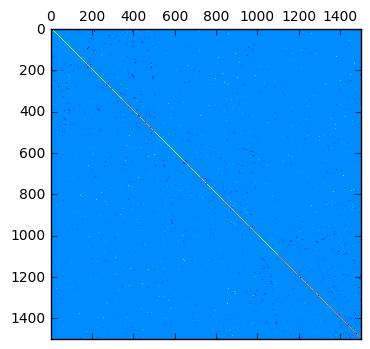

In [9]:
try:
    plt.matshow(A)
except:
    plt.matshow(A.toarray())

## Experiment initialization

### Experiment parameters

In [10]:
# Parameters that may change during the experiment
# Experiment parameters override Algorithm parameters
experiment_parameters = Parameters()

experiment_parameters["vulnerable"] = False
experiment_parameters["tol"] = epsilon
experiment_parameters["full"] = False

In [11]:
F = Experiment(experiment_parameters, gmres_algorithm)
F.set_inputs(inputs)

## Run experiment

In [12]:
F.run(show_progress=True, n=1)

Complete ! 


In [13]:
minimum = min(filter(lambda d: d[1] < epsilon, enumerate(F.get_data("residuals")[0])),
                    key=lambda d: d[0])
print minimum
min_iteration = minimum[0]
print min_iteration

(497, 7.25391787560352e-11)
497


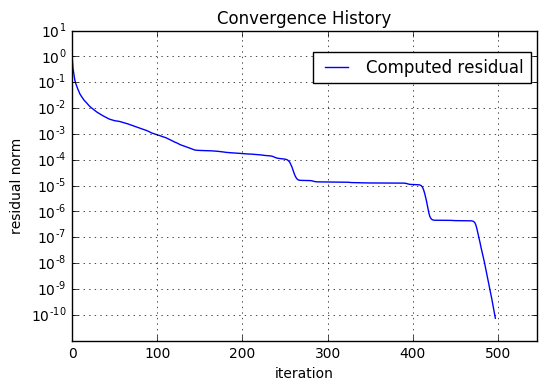

In [14]:
gmres_display.convergence_history(F.get_data()[0], xlim = (0, int(min_iteration * 1.1)), ylim = (epsilon / 10, 10), true_residual = False, checksum = False, threshold = False, c = 1, delta = False)

## Effect of faults in GMRES

### Experiment parameters

In [15]:
# Parameters that may change during the experiment
experiment_parameters = Parameters()

experiment_parameters["vulnerable"] = True
experiment_parameters["iterMax"] = int(1.5 * min_iteration)
experiment_parameters["m"] = int(1.5* min_iteration)
fault_parameters = {}
fault_parameters["fault_callback"] = lambda fault: (stdout.write(" %s " % str(fault)))
fault_parameters["register"] = 2
fault_parameters["vulnerable"] = True
fault_parameters["vulnerable_bits"] = [int(np.random.rand() * 64)]
non_zero = A.nonzero()
index = int(np.random.rand()*len(non_zero[0]))
fault_parameters["fault_indices"] = {"i": non_zero[0][index], 
                                     "j":0, 
                                     "k": non_zero[1][index]}
fault_parameters["timer"] = int(np.random.rand() * min_iteration) + 1
experiment_parameters["fault_parameters"] = fault_parameters


In [16]:
E = Experiment(experiment_parameters, gmres_algorithm)
E.set_inputs(inputs)
E.run(show_progress=True, n=1)

Complete ! 


### Parameters influence

In [17]:
def experiment_parameters_generator(vulnerable = True,
                                    tol = 0,
                                    bits = [40], 
                                    iterations = [min_iteration / 2], 
                                    iterMax = int(min_iteration * 1.5),
                                    m = int(min_iteration * 1.5),
                                    registers = [1], 
                                    indices = [E.get_data("faults")[0][0]["loc"]],
                                    fault_callback = lambda fault: (stdout.write(" %s " % str(fault)))
                                   ):
    parameters = Parameters()
    parameters["vulnerable"] = vulnerable
    parameters["tol"] = epsilon #tol
    parameters["iterMax"] = iterMax
    parameters["m"] = m
    fault_parameters = {}
    fault_parameters["fault_callback"] = fault_callback
    fault_parameters["vulnerable"] = vulnerable
    while (True):

        parameters["fault_parameters"] = fault_parameters

        for bit in bits:
            for iteration in iterations:
                for reg in registers:
                    for indice in indices:
                        fault_parameters["vulnerable_bits"] = [bit]
                        fault_parameters["timer"] = iteration
                        fault_parameters["register"] = reg
                        fault_parameters["fault_indices"] = indice
                        yield parameters

In [18]:
def has_converged(data, epsilon = epsilon):
    return len(filter (lambda d: d[0] < epsilon and d[1] < epsilon, zip(data["true_residuals"], data["residuals"]))) > 0

def when_has_converged(data, epsilon = epsilon):
    iteration_residual = filter (lambda d: d[1][0] < epsilon and d[1][1] < epsilon, 
                                 enumerate(zip(data["true_residuals"], data["residuals"])))
    if iteration_residual:
        return min(iteration_residual, key=lambda d:d[0])[0]
    else:
        return None

## Quantitative results

In [19]:
import random

def experiment_parameters_generator_random(vulnerable = True,
                                    tol = 0,
                                    m = 100,
                                    fault_callback = lambda fault: (stdout.write(" %s " % str(fault)))
                                   ):

    
    parameters = Parameters()
    parameters["vulnerable"] = vulnerable
    parameters["tol"] = tol
    fault_parameters = {}
    fault_parameters["fault_callback"] = fault_callback
    fault_parameters["vulnerable"] = vulnerable
            
    parameters["fault_parameters"] = fault_parameters
        
    while (True):
        fault_parameters["timer"] = random.choice([i for i in xrange(m)])
        yield parameters

In [35]:
import os
import sys
#import mysql.connector as mariadb
import pymysql as mariadb
mariadb_connection = mariadb.connect(user='resilience', 
                                     #password='resilience_password', 
                                     passwd='resilience_password',
                                     host='192.168.1.48',
                                     database='gmres_resilience')
cursor = mariadb_connection.cursor()

def save_linearsystem(input):
    try:
        cursor.execute("""SELECT name FROM LinearSystem WHERE name = %s """, (str(input["name"]),))
        rows = cursor.fetchone()
        if (not rows):
            cursor.execute("""INSERT INTO LinearSystem (file, name) VALUES (%s,%s)""",(input["file"], str(input["name"])))
            mariadb_connection.commit()
            return
    except:
        print sys.exc_info()[0]
    mariadb_connection.rollback()
        
def save_experiment(input, output, parameter, data):
    print ("""INSERT INTO Experiment (LinearSystem, H, V, x, residual, residuals, givens_c, givens_s, tol, m, l) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)""" %
                        (str(input["name"]),
                        data["H"].tostring(), 
                        data["V"].tostring(),
                        output.tostring(), 
                        float(data["residual"]), 
                        np.asarray(data["residuals"]).tostring(),
                        np.asarray(data["givens_c"]).tostring(),
                        np.asarray(data["givens_s"]).tostring(),
                        float(parameter["tol"]),
                        int(parameter["m"]),
                        int(data["iteration_count"])))
        
    try:
        if data["faults"]:
            cursor.execute("""INSERT INTO Experiment (fault_i, fault_k, fault_f, fault_bit, fault_reg, LinearSystem, H, V, x, residual, residuals, givens_c, givens_s, tol, m, l) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)""", 
                       (int(data["faults"][0]["loc"]["i"]),
                        int(data["faults"][0]["loc"]["k"]),
                        int(data["faults"][0]["timer"]),
                        int(data["faults"][0]["bit"]),
                        int(data["faults"][0]["register"]),
                        str(input["name"]),
                        data["H"].tostring(), 
                        data["V"].tostring(),
                        output.tostring(), 
                        float(data["residual"]), 
                        np.asarray(data["residuals"]).tostring(),
                        np.asarray(data["givens_c"]).tostring(),
                        np.asarray(data["givens_s"]).tostring(),
                        float(parameter["tol"]),
                        int(parameter["m"]),
                        int(data["iteration_count"])))
        else:
            cursor.execute("""INSERT INTO Experiment (LinearSystem, H, V, x, residual, residuals, givens_c, givens_s, tol, m, l) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)""", 
                        (str(input["name"]),
                        data["H"].tostring(), 
                        data["V"].tostring(),
                        output.tostring(), 
                        float(data["residual"]), 
                        np.asarray(data["residuals"]).tostring(),
                        np.asarray(data["givens_c"]).tostring(),
                        np.asarray(data["givens_s"]).tostring(),
                        float(parameter["tol"]),
                        int(parameter["m"]),
                        int(data["iteration_count"])))
        mariadb_connection.commit()
        return

    except:
        print sys.exc_info()[0]
    mariadb_connection.rollback()
    
def save_database_callback(input, output, parameter, data):
    save_linearsystem(input)
    save_experiment(input, output, parameter, data)

In [32]:
cursor.execute("""SELECT name FROM LinearSystem WHERE name = %s """, (str(input["name"]),))
rows = cursor.fetchone()
print rows

None


In [ ]:

F_parameters = Parameters()
F_parameters["restart"] = None
F_parameters["tol"] = epsilon
F_parameters["save_data"] = {"iteration_count",
                             "residual",
                             "residuals",
                             "true_residual",
                             "true_residuals",
                             "faults",
                             "H",
                             "V",
                             "givens",
                             "y",
                             "checksum",
                             "delta",
                             "true_delta"
                            }
F_parameters["vulnerable"] = False


for mat_file in os.listdir(os.getcwd()+os.sep+"mat_files", ):
    try:
        if mat_file.endswith(".mat"): 
            print mat_file
            _inputs = [load_mat(os.getcwd()+os.sep+"mat_files"+os.sep+mat_file, sparse = True)]
            _F = Experiment(F_parameters, gmres_algorithm, callback=save_database_callback, save_data=True)
            _F.set_inputs(_inputs)
            _F.run(n = 1)
            if has_converged(_F.get_data()[0], epsilon = epsilon):
                _min_iteration = when_has_converged(_F.get_data()[0], epsilon = epsilon)
                if _min_iteration and _min_iteration > 5:
                    _G = Experiment(experiment_parameters_generator_random(m=_min_iteration, tol = epsilon / 100), 
                                    gmres_algorithm, 
                                    callback=save_database_callback,
                                    save_data = False)
                    _G.set_inputs(_inputs)
                    _G.run(show_progress=True, n=100)
                    #_data = filter(lambda d: len(d["faults"]) > 0 and not d["breakdown"], _G.get_data())
    except RuntimeError:
        print "Problème avec ", mat_file

coater1.mat


In [ ]:
mariadb_connection.close()

## Fault detection

### Qualitative results

In [ ]:
input = load_mat("./gre_216a.mat", sparse = False)
A = input["A"]
inputs = [input]
n = A.shape[0]

min_iteration = when_has_converged(F.get_data()[0], epsilon=epsilon)


In [ ]:

experiment_parameters = experiment_parameters_generator(iterations = [60], tol = epsilon)

E_ = Experiment(experiment_parameters, gmres_algorithm)
E_.set_inputs(inputs)
E_.run(show_progress=True, n=3)

In [ ]:
for data, result in zip(E_.get_data(), E_.get_results()):
    for i in xrange(len(data["threshold"])):
        data["delta"][i] = (c * epsilon * np.linalg.norm(result[0]["b"])) / abs(data["y"][-1][i])
    data["delta"][-1] = (c * epsilon * np.linalg.norm(result[0]["b"])) / abs(data["y"][-1][-2])   


In [ ]:
for data in E_.get_data():
    gmres_display.convergence_history(data, data_no_fault = F.get_data()[0], true_residual=False, computed_residual=False, fault = True, delta = True, delta_label="True threshold", threshold=True, ylim = (epsilon / 10, 1), xytext = (1, epsilon / 10), bbox_to_anchor=(0.52, 0.15))
    #plt.plot([data["faults"][0]["timer"]], [abs(data["faults"][0]["value_before"]- data["faults"][0]["value_after"])], 'bs', label='true error')
    #plt.legend(numpoints=1)
    plt.show()

In [ ]:
for data in E_.get_data():
    gmres_display.convergence_history(data, data_no_fault = F.get_data()[0], c = 0.5, fault = True, delta = True, checksum=True, threshold = True, xlim = (0, int(1.5 * min_iteration)), ylim = (epsilon / 10, 1), xytext = (1, epsilon / 10), bbox_to_anchor=(0.6, 0.8))
    plt.show()

In [ ]:
def criterion(data, c = 0.25, epsilon = epsilon):
    m = when_has_converged(data, epsilon = (1-c)*epsilon)
    if len(data["checksum"]) >= m and len(data["threshold"]) >= m:
        return reduce(lambda d, e: d and (e[0] < c * e[1]), zip(data["checksum"][:m], data["threshold"][:m])) and data["checksum"][0] < c * data["threshold"][0]
    else:
        return True

In [ ]:
print criterion(E_.get_data()[0])
print criterion(E_.get_data()[1])
print criterion(E_.get_data()[2])

In [ ]:

step_ite = 1
step_bit = 1

experiment_parameters = experiment_parameters_generator(bits = np.arange(63, 0, -step_bit),
                                                       iterations = np.arange(0, min_iteration, step_ite),
                                                       tol = epsilon / 2)

I = Experiment(experiment_parameters, gmres_algorithm)
I.set_inputs(inputs)
I.run(show_progress=True, n=int(math.ceil(float(min_iteration)/step_ite)) * int(math.ceil(64./step_bit)))

In [ ]:
for data, result in zip(I.get_data(), I.get_results()):
    for i in xrange(len(data["checksum"])):
        data["checksum"][i] = epsilon / 10
    data["checksum"][data["faults"][0]["timer"]] = abs(data["faults"][0]["value_before"]- data["faults"][0]["value_after"])

In [ ]:
#for data, result in zip(I.get_data(), I.get_results()):
#    for i in xrange(len(data["threshold"])):
#        data["threshold"][i] = (np.linalg.norm(result[0]["b"]) * epsilon) / abs(data["y"][i][i][0])
for data, result in zip(I.get_data(), I.get_results()):
    for i in xrange(len(data["threshold"])):
        data["threshold"][i]= (np.linalg.norm(result[0]["b"]) * epsilon) / abs(data["y"][-1][data["faults"][0]["timer"]][0])

In [ ]:
data = filter(lambda d: len(d["faults"]) > 0, I.get_data())


In [ ]:

for d in filter(lambda d: fault_detection(d, epsilon = epsilon, c=0.5), data)[0:1]:
    gmres_display.convergence_history(d, data_no_fault = F.get_data()[0], c = 0.5, fault = True, delta = True, checksum=True, checksum_label="Error", threshold = True, xlim = (0, int(1.5 * min_iteration)), ylim = (epsilon/10, 1), xytext = (1, epsilon / 10), bbox_to_anchor=(0.50, 0.72))
    plt.show()

In [ ]:

X = [1.2**(-50+i) for i in xrange(51)]
test_orange = []
test_red = []
test_green = []
test_gray1 = []
test_gray2 = []


for x in X:
    #test_red += [(100. * len(filter_data(data, {'converged':False, 'criterion':True}, c=x)))/len(data)]
    #test_green += [(100. * len(filter_data(data, {'converged':False, 'criterion':False}, c=x)))/len(data)]
    #test_gray1 += [(100. * len(filter_data(data, {'converged':True, 'criterion':True}, c=x)))/len(data)]
    #test_gray2 += [(100. * len(filter_data(data, {'converged':True, 'criterion':False}, c=x)))/len(data)]

    test_orange += [(100. * len(filter(lambda d: false_detection(d, epsilon = epsilon, c=x), data)))/len(data)]
    test_red += [(100. * len(filter(lambda d: fault_no_detection(d, epsilon = epsilon, c=x), data)))/len(data)]
    test_green += [(100. * len(filter(lambda d: fault_detection(d, epsilon = epsilon, c=x), data)))/len(data)]
    test_gray1 += [(100. * len(filter(lambda d: no_impact_fault_no_detection(d, epsilon = epsilon, c=x), data)))/len(data)]
    test_gray2 += [(100. * len(filter(lambda d: no_impact_fault_detection(d, epsilon = epsilon, c=x), data)))/len(data)]
    

Y = np.row_stack((test_gray1, test_gray2, test_green, test_red))   
Y = np.cumsum(Y, axis=0)  

fig = plt.figure()
ax = fig.add_subplot(111)

#ax.plot(X, test_orange, c="orange", linestyle="--")
ax.fill_between(X, 0, Y[0,:], facecolor="lightgray", alpha=.7, label="No impact fault not detected")
ax.fill_between(X, Y[0,:], Y[1,:], facecolor="darkgray", alpha=.7, label="No impact fault detected")
ax.fill_between(X, Y[1,:], Y[2,:], facecolor="green", alpha=.7, label="Critical fault detected")
ax.fill_between(X, Y[2,:], Y[3,:], facecolor="red",alpha=.7, label="Critical fault not detected")
ax.set_xscale('log')
ax.set_ylim([0, 100])
ax.set_xlim([0.0001, 1])
ax.set_xlabel("c")
ax.set_ylabel("%")
ax.set_title("Test result repartition")

p1 = plt.Rectangle((0, 0), 1, 1, fc="green", alpha=.7)
p2 = plt.Rectangle((0, 0), 1, 1, fc="lightgray", alpha=.7)
p3 = plt.Rectangle((0, 0), 1, 1, fc="darkgray", alpha=.7)
p4 = plt.Rectangle((0, 0), 1, 1, fc="red", alpha=.7)
plt.legend([p1, p2, p3, p4], ["Critical fault detected", "No impact fault ignored", "No impact fault detected", "Critical fault ignored"], loc=4)
plt.plot([0.5, 0.5], [0, 100], c = "red", linestyle = "--")
plt.show()

In [ ]:
c = 0.5

In [ ]:
for d in filter(lambda d: fault_no_detection(d, epsilon = epsilon, c=0.5), data)[0:10]:
    gmres_display.convergence_history(d, data_no_fault = F.get_data()[0], c = 0.5, fault = True, delta = True, checksum=True, threshold = True, ylim = (1.e-16, 1), xytext = (1, 1.e-16), bbox_to_anchor=(0.6, 0.8))
    print d["faults"][0]
    k = d["faults"][0]["timer"]
    print d["y"][d["faults"][0]["timer"]][d["faults"][0]["timer"]]
    print d["threshold"][d["faults"][0]["timer"]]
    print d["checksum"][d["faults"][0]["timer"]]
    print d["H"][k, k]
    plt.matshow(d["V"])
    plt.matshow(d["H"])
    plt.show()

In [ ]:


gmres_display.show_test_result(data, F.get_data()[0], c=c, epsilon = epsilon)    
plt.show()



In [ ]:
import os

epsilon = epsilon
c = 0.5

F_parameters["restart"] = None
F_parameters["tol"] = epsilon / 1000
F_parameters["save_data"] = {"iteration_count",
                             "residual",
                             "residuals",
                             "true_residual",
                             "true_residuals",
                             "faults",
                             "H",
                             "V",
                             "y",
                             "checksum",
                             "delta",
                             "true_delta"
                            }
F_parameters["vulnerable"] = False

for mat_file in os.listdir(os.getcwd())[:1]:
    #try:
        if mat_file.endswith(".mat"): 
            
            _inputs = [load_mat(mat_file, sparse = True)]
            _F = Experiment(Parameters({"tol":epsilon}), gmres_algorithm)
            _F.set_inputs(_inputs)
            _F.run(n = 1)
            if has_converged(F.get_data()[0], epsilon = epsilon):
                _min_iteration = when_has_converged(_F.get_data()[0], epsilon = epsilon)
                if _min_iteration and _min_iteration > 4:
                    _G = Experiment(experiment_parameters_generator_random(m=_min_iteration, tol = (1-c)*epsilon), gmres_algorithm)
                    _G.set_inputs(inputs)
                    _G.run(show_progress=True, n=500)
                    _data = filter(lambda d: len(d["faults"]) > 0, _G.get_data())
                    gmres_display.show_test_result(_data, _F.get_data()[0], c = c, epsilon = epsilon)
                    print mat_file
    #except RuntimeError:
        #print "Problem with ", mat_file
        #pass


